In [13]:
# pip install git+https://github.com/xunzheng/notears.git

In [14]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from notears.linear import notears_linear
import networkx as nx
import matplotlib.pyplot as plt

# 데이터 전처리
df = pd.read_csv("training_data.csv")
# X = df.values
# label 제거 필요
X = df.drop(columns=["Unnamed: 0", "label"]).values
X = StandardScaler().fit_transform(X)

# NOTEARS 실행
W = notears_linear(X, lambda1=0.1, loss_type='l2')  # lambda1으로 sparsity 조절

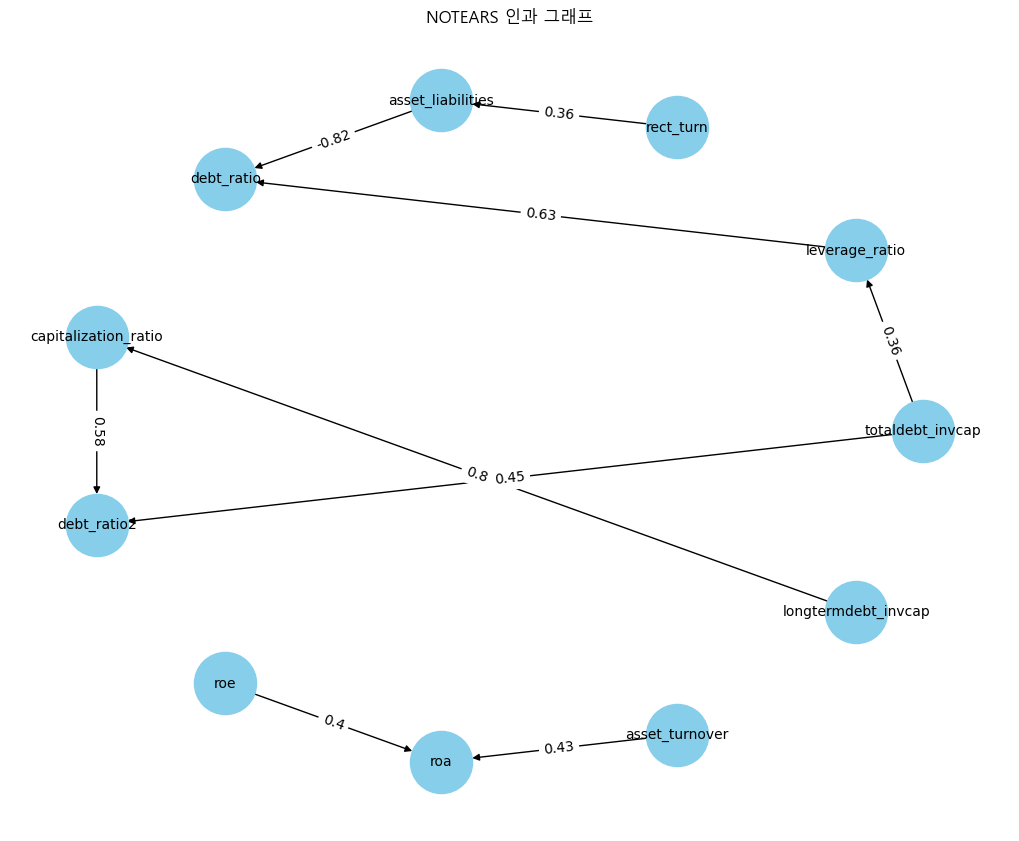

In [15]:
import matplotlib
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
matplotlib.rcParams['axes.unicode_minus'] = False


# 인과 그래프 시각화
cols = df.columns[1:-1]  # label 제외한 열 이름
G = nx.DiGraph()

for i in range(len(cols)):
    for j in range(len(cols)):
        if abs(W[i, j]) > 0.01:  # threshold 적용(0 제외)
            G.add_edge(cols[j], cols[i], weight=round(W[i, j], 2))

plt.figure(figsize=(10, 8))
# pos = nx.spring_layout(G)
# pos = nx.shell_layout(G)
# pos = nx.kamada_kawai_layout(G)
pos = nx.circular_layout(G)

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, 'weight'))
plt.title("NOTEARS 인과 그래프")
plt.show()


In [16]:
# -*- coding: utf-8 -*-
"""
Standalone SHAP analysis script
- Settings: original / feature_only / original_plus_feature
- One stratified holdout split per mode & setting (not full CV)
- Saves: beeswarm.png, bar.png, mean_abs_shap.csv per (setting, mode)
"""
import os
import re
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
import shap
import matplotlib.pyplot as plt

# -----------------------------
# 0) Paths & basic config
# -----------------------------
SAVE_DIR = Path("./shap_outputs")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

RANDOM_STATE = 42
TEST_SIZE = 0.2          # 홀드아웃 비율
TOP_N = 20               # SHAP summary 상위 표시 개수

# XGB Grid
PARAM_GRID = {
    "xgb__n_estimators": [150],
    "xgb__max_depth": [7],
    "xgb__learning_rate": [0.1],
    "xgb__subsample": [0.8],
}

# -----------------------------
# 1) Modes & name helpers
# -----------------------------
MODES = [
    "original",
    "mul",
    "sub",
    "mul*w",
    "sub*w",
    "mul+sub",
    "mul+mul*w",
    "mul+sub*w",
    "sub+mul*w",
    "sub+sub*w",
    "mul*w+sub*w",
    "mul+mul*w+sub*w",
    "mul+sub+mul*w",
    "mul+sub+sub*w",
    "sub+mul*w+sub*w",
    "mul+sub+mul*w+sub*w",
]

def safe_name(name: str) -> str:
    # Windows 금지문자 제거
    name = name.replace("+", "_").replace("*", "_")
    return re.sub(r'[<>:"/\\|?*\s]+', "_", name)

def short_mode_name(mode: str) -> str:
    # mul*w→mw, sub*w→sw, mul→m, sub→s
    s = mode
    s = s.replace("mul*w", "mw").replace("sub*w", "sw")
    s = s.replace("mul", "m").replace("sub", "s")
    return safe_name(s)

# -----------------------------
# 2) Data & causal features
# -----------------------------
# 준비: training_data.csv에 "Unnamed: 0", "label" 컬럼 존재 가정
df = pd.read_csv("./training_data.csv")
X_base = df.drop(columns=["Unnamed: 0", "label"])
y = df["label"].astype(int)
cols = X_base.columns.tolist()

# 주의: W는 (len(cols), len(cols))인 인과 가중치 행렬이어야 함 (외부에서 준비)
# 예) W = np.load("W.npy")
# 여기서는 존재한다고 가정
# W = ...

def generate_added_features(X_base: pd.DataFrame, cols, W: np.ndarray, mode: str,
                            w_threshold: float = 0.01) -> pd.DataFrame:
    """
    원본 제외, 추가 피처만 생성.
    mode 문자열에 'mul', 'sub', 'mul*w', 'sub*w' 포함 여부로 조합.
    방향성 i←j (행 i, 열 j)에서 |w_ij| > threshold만 사용.
    """
    new_features = pd.DataFrame(index=X_base.index)

    for i in range(len(cols)):
        for j in range(len(cols)):
            w_ij = W[i, j]
            if abs(w_ij) <= w_threshold:
                continue

            A = cols[j]  # 원인(부모)로 해석
            B = cols[i]  # 결과(자식)로 해석
            mul = X_base[A] * X_base[B]
            sub = X_base[A] - X_base[B]

            if mode == "original":
                continue

            # 미가중
            if "mul" in mode and "mul*w" not in mode:
                new_features[f"{A}_mul_{B}"] = mul
            if "sub" in mode and "sub*w" not in mode:
                new_features[f"{A}_sub_{B}"] = sub

            # 가중
            if "mul*w" in mode:
                new_features[f"{A}_mulw_{B}"] = w_ij * mul
            if "sub*w" in mode:
                new_features[f"{A}_subw_{B}"] = w_ij * sub

    return new_features

# -----------------------------
# 3) Build dataset by setting
# -----------------------------
def build_dataset_by_setting(mode: str, setting: str, X_base: pd.DataFrame,
                             cols, W: np.ndarray) -> pd.DataFrame:
    """
    setting ∈ {"original", "feature_only", "original_plus_feature"}
    """
    if setting == "original":
        return X_base.copy()

    X_added = generate_added_features(X_base, cols, W, mode)
    if setting == "feature_only":
        return X_added

    if setting == "original_plus_feature":
        return pd.concat([X_base, X_added], axis=1)

    raise ValueError(f"Unknown setting: {setting}")


c:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
# -----------------------------
# 4) SHAP core
# -----------------------------
def fit_and_shap(X: pd.DataFrame, y: pd.Series, save_dir: Path,
                 tag: str, # ex) "feature_only_m_s"
                 random_state: int = RANDOM_STATE,
                 test_size: float = TEST_SIZE,
                 param_grid: dict = PARAM_GRID,
                 top_n: int = TOP_N):
    """
    - StratifiedShuffleSplit → best model via GridSearchCV
    - Pipeline(scaler + xgb)
    - Compute SHAP on X_test (held-out)
    - Save beeswarm / bar / mean_abs_shap.csv
    """
    save_dir.mkdir(parents=True, exist_ok=True)

    # 홀드아웃 분할
    splitter = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    (train_idx, test_idx), = splitter.split(X, y)
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # XGB with scaling inside Pipeline (해석 편의성을 위해 입력은 원본 스케일, 내부는 표준화)
    pipe = Pipeline([
        ("scaler", StandardScaler(with_mean=False) if hasattr(X_train, "sparse") else StandardScaler()),
        ("xgb", XGBClassifier(
            eval_metric="logloss",
            random_state=random_state,
            tree_method="hist"
        ))
    ])

    # 클래스 불균형 보정 값 계산 (fold마다 다를 수 있음)
    pos = int((y_train == 1).sum())
    neg = int((y_train == 0).sum())
    spw = (neg / pos) if pos > 0 else 1.0

    # 그리드서치: scale_pos_weight을 고정 파라미터로 set_params
    pipe.set_params(xgb__scale_pos_weight=spw)

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="f1",
        cv=3,
        n_jobs=-1,
        verbose=0
    )
    grid.fit(X_train, y_train)

    best_pipe: Pipeline = grid.best_estimator_
    # 파이프라인 내부 변환 후 입력(= best_pipe[:-1].transform(X_test))에 대해 SHAP 계산
    # TreeExplainer는 트리 모델 원본 입력을 기대하지만, 파이프라인으로도 사용 가능
    # 여기서는 "모델 입력" 기준 SHAP(스케일 후)로 계산
    X_test_trans = best_pipe.named_steps["scaler"].transform(X_test)
    xgb_model = best_pipe.named_steps["xgb"]

    # 컬럼명
    feature_names = list(X.columns)

    # shap 계산
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_test_trans)

    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_for_plot = shap_values[1]
    else:
        shap_for_plot = shap_values

    # DataFrame로 래핑 (그림에 컬럼명 표기)
    X_test_trans_df = pd.DataFrame(X_test_trans, columns=feature_names)

    # 1) beeswarm
    plt.figure()
    shap.summary_plot(shap_for_plot, X_test_trans_df, show=False, plot_type="dot", max_display=top_n)
    plt.tight_layout()
    beeswarm_path = save_dir / f"{tag}_shap_beeswarm.png"
    plt.savefig(beeswarm_path, dpi=180, bbox_inches="tight")
    plt.close()

    # 2) bar
    plt.figure()
    shap.summary_plot(shap_for_plot, X_test_trans_df, show=False, plot_type="bar", max_display=top_n)
    plt.tight_layout()
    bar_path = save_dir / f"{tag}_shap_bar.png"
    plt.savefig(bar_path, dpi=180, bbox_inches="tight")
    plt.close()

    # 3) mean |SHAP|
    mean_abs = np.abs(shap_for_plot).mean(axis=0)
    imp_df = (
        pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
        .sort_values("mean_abs_shap", ascending=False)
        .reset_index(drop=True)
    )
    imp_csv = save_dir / f"{tag}_shap_mean_abs.csv"
    imp_df.to_csv(imp_csv, index=False)

    # (선택) 간단한 콘솔 로그
    print(f"[SHAP saved] {tag}")
    print(f"- beeswarm: {beeswarm_path}")
    print(f"- bar     : {bar_path}")
    print(f"- meanabs : {imp_csv}")



In [18]:
# -----------------------------
# 5) Run for 3 settings
# -----------------------------
def run_all_settings(X_base, y, cols, W):
    SETTINGS = ["original", "feature_only", "original_plus_feature"]
    for setting in SETTINGS:
        set_dir = SAVE_DIR / setting
        set_dir.mkdir(parents=True, exist_ok=True)

        for mode in MODES:
            # setting=original일 때 mode는 의미 없지만, 인터페이스 단일화를 위해 반복
            X = build_dataset_by_setting(mode, setting, X_base, cols, W)
            if X is None or X.shape[1] == 0:
                print(f"[skip] setting={setting}, mode={mode}: no features.")
                continue

            # tag & dir
            mode_short = short_mode_name(mode)
            tag = f"{setting}_{mode_short}"
            subdir = set_dir / mode_short
            subdir.mkdir(parents=True, exist_ok=True)

            # SHAP
            try:
                fit_and_shap(X, y, subdir, tag)
            except Exception as e:
                print(f"[error] setting={setting}, mode={mode}: {e}")



In [19]:
# -----------------------------
# 6) Entry
# -----------------------------
if __name__ == "__main__":
    # W가 준비되어 있어야 합니다.
    try:
        W
    except NameError:
        raise RuntimeError("W (causal weight matrix)가 정의되어 있지 않습니다. W를 먼저 로드하세요.")
    run_all_settings(X_base, y, cols, W)


[SHAP saved] original_original
- beeswarm: shap_outputs\original\original\original_original_shap_beeswarm.png
- bar     : shap_outputs\original\original\original_original_shap_bar.png
- meanabs : shap_outputs\original\original\original_original_shap_mean_abs.csv
[SHAP saved] original_m
- beeswarm: shap_outputs\original\m\original_m_shap_beeswarm.png
- bar     : shap_outputs\original\m\original_m_shap_bar.png
- meanabs : shap_outputs\original\m\original_m_shap_mean_abs.csv
[SHAP saved] original_s
- beeswarm: shap_outputs\original\s\original_s_shap_beeswarm.png
- bar     : shap_outputs\original\s\original_s_shap_bar.png
- meanabs : shap_outputs\original\s\original_s_shap_mean_abs.csv
[SHAP saved] original_mw
- beeswarm: shap_outputs\original\mw\original_mw_shap_beeswarm.png
- bar     : shap_outputs\original\mw\original_mw_shap_bar.png
- meanabs : shap_outputs\original\mw\original_mw_shap_mean_abs.csv
[SHAP saved] original_sw
- beeswarm: shap_outputs\original\sw\original_sw_shap_beeswarm.